# Data 512A Homework 1 Professionalism & Reproducibility

### Andy Wang, 10/6/2022

## Step 1: Data Acquisition

In this step, I followed the exmaple code notebook to request data from [Wikimedia REST API](https://www.mediawiki.org/wiki/Wikimedia_REST_API).
- Define Constants, Functions, and Parameters
- Loop for each article name and Request data from API for desktop, mobile-app, and mobile-web
- Save the temporary raw dinosaur json data for desktop, mobile-app, and mobile-web from July 2015 - Sept 2022 to local

In [1]:
#########
#
#    IMPORT MODULES/PACKAGES
#

# These are standard python modules
import json, time, urllib.parse
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests

In [2]:
#########
#
#    CONSTANTS
#

# The REST API 'pageviews' URL - this is the common URL/endpoint for all 'pageviews' API requests
API_REQUEST_PAGEVIEWS_ENDPOINT = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/'

# This is a parameterized string that specifies what kind of pageviews request we are going to make
# In this case it will be a 'per-article' based request. The string is a format string so that we can
# replace each parameter with an appropriate value before making the request
API_REQUEST_PER_ARTICLE_PARAMS = 'per-article/{project}/{access}/{agent}/{article}/{granularity}/{start}/{end}'

# The Pageviews API asks that we not exceed 100 requests per second, we add a small delay to each request
API_LATENCY_ASSUMED = 0.002       # Assuming roughly 2ms latency on the API and network
API_THROTTLE_WAIT = (1.0/100.0)-API_LATENCY_ASSUMED

# When making a request to the Wikimedia API they ask that you include a "unique ID" that will allow them to
# contact you if something happens - such as - your code exceeding request limits - or some other error happens
REQUEST_HEADERS = {
    'User-Agent': 'wangqc@uw.edu, University of Washington, MSDS DATA 512 - AUTUMN 2022',
}

# This is just a list of English Wikipedia article titles that we can use for example requests

dinosaur_list = pd.read_csv("dinosaur_genera.cleaned.SEPT.2022.csv")
ARTICLE_TITLES = dinosaur_list["name"].tolist()
ARTICLE_TITLES[0] = '"Coelosaurus"_antiquus'

In [3]:
#########
#
#    PARAMETERS
#


# The template is used to map parameter values into the API_REQUST_PER_ARTICLE_PARAMS portion of an API request. The dictionary has a
# field/key for each of the required parameters.

# set a template for desktop access data from July 2015 - Sept 2022
ARTICLE_PAGEVIEWS_DESKTOP_PARAMS_TEMPLATE = {
    "project":     "en.wikipedia.org",
    "access":      "desktop",      
    "agent":       "user",
    "article":     "",             
    "granularity": "monthly",
    "start":       "2015070100",
    "end":         "2022093000"    
}

# set a template for mobile-app access data from July 2015 - Sept 2022
ARTICLE_PAGEVIEWS_MOBILEAPP_PARAMS_TEMPLATE = {
    "project":     "en.wikipedia.org",
    "access":      "mobile-app",      
    "agent":       "user",
    "article":     "",             
    "granularity": "monthly",
    "start":       "2015070100",
    "end":         "2022093000"    
}

# set a template for mobile-web access data from July 2015 - Sept 2022
ARTICLE_PAGEVIEWS_MOBILEWEB_PARAMS_TEMPLATE = {
    "project":     "en.wikipedia.org",
    "access":      "mobile-web",      
    "agent":       "user",
    "article":     "",             
    "granularity": "monthly",
    "start":       "2015070100",
    "end":         "2022093000"  
}

In [4]:
#########
#
#    PROCEDURES/FUNCTIONS
#

# Function copied from example notebook
def request_pageviews_per_article(article_title = None, 
                                  endpoint_url = API_REQUEST_PAGEVIEWS_ENDPOINT, 
                                  endpoint_params = API_REQUEST_PER_ARTICLE_PARAMS, 
                                  request_template = None,
                                  headers = REQUEST_HEADERS):
    # Make sure we have an article title
    if not article_title: return None
    
    # Make sure we have an request_template
    if not request_template: return None
    
    # Titles are supposed to have spaces replaced with "_" and be URL encoded
    article_title_encoded = urllib.parse.quote(article_title.replace(' ','_'))
    request_template['article'] = article_title_encoded
    
    # now, create a request URL by combining the endpoint_url with the parameters for the request
    request_url = endpoint_url+endpoint_params.format(**request_template)
    
    # make the request
    try:
        # we'll wait first, to make sure we don't exceed the limit in the situation where an exception
        # occurs during the request processing - throttling is always a good practice with a free
        # data source like Wikipedia - or other community sources
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response

# function for write json file to local
def json_dump(file_path, json_data):
    with open(file_path, 'w') as f:
        json.dump(json_data, f)

# function for load json file from local as pandas DataFrame
def json_as_dataframe(file_path):
    with open(file_path) as f:
        json_data = json.load(f)
        df = pd.DataFrame(json_data["items"])
    return df

In [5]:
#########
#
#    Request
#

# request API to load desktop data
# create a empty json dictionary to save request data
monthly_desktop = {"items" : []}
# loop for different article names
for i in range(len(ARTICLE_TITLES)):
    monthly_desktop["items"].extend(request_pageviews_per_article(article_title=ARTICLE_TITLES[i], request_template=ARTICLE_PAGEVIEWS_DESKTOP_PARAMS_TEMPLATE)["items"])

# similar process as above for mobile-app data
monthly_mobileapp = {"items" : []}
for i in range(len(ARTICLE_TITLES)):
    monthly_mobileapp["items"].extend(request_pageviews_per_article(article_title=ARTICLE_TITLES[i], request_template=ARTICLE_PAGEVIEWS_MOBILEAPP_PARAMS_TEMPLATE)["items"])
    
# similar process as above for mobile-web data
monthly_mobileweb = {"items" : []}
for i in range(len(ARTICLE_TITLES)):
    monthly_mobileweb["items"].extend(request_pageviews_per_article(article_title=ARTICLE_TITLES[i], request_template=ARTICLE_PAGEVIEWS_MOBILEWEB_PARAMS_TEMPLATE)["items"])

In [6]:
#########
#
#    Save temporary json data to local
#

# save the three different access data to local as json file
json_dump("monthly_desktop_201507-202209.json", monthly_desktop)
json_dump("monthly_mobileapp_201507-202209.json", monthly_mobileapp)
json_dump("monthly_mobileweb_201507-202209.json", monthly_mobileweb)

## Step 2: Data Processing

In this step, I load the saved json data, processed them as PandasDataFrame, and Save the three cleaned files as Json.
- Load the raw data as Pandas Dataframe
- Remove Access column
- Merge mobile-app data with mobile-web data
- Merge all three data, and calculate cumulative views with Pandas cumsum() function
- Save cleaned Pandas DataFrames as final Json files: dino_monthly_mobile_201507-202209.json;  dino_monthly_desktop_201507-202209.json; dino_monthly_cumulative_201507-202209.json

In [7]:
#########
#
#    Clean mobile data with pandas and write to disk as 'dino_monthly_mobile_201507-202209.json'
#

# read in saved json file as pandas dataframe
df_monthly_mobileapp = json_as_dataframe("monthly_mobileapp_201507-202209.json")
df_monthly_mobileweb = json_as_dataframe("monthly_mobileweb_201507-202209.json")
# Merge mobile-app data with mobile-web data
df_monthly_mobile = df_monthly_mobileapp.merge(df_monthly_mobileweb, on=['project', 'article','timestamp','agent','granularity'], how='outer')
# Sum up total monthly views for mobile data
df_monthly_mobile['views'] = df_monthly_mobile['views_x'] + df_monthly_mobile['views_y']
# drop repeated columns and 'access' column
df_monthly_mobile = df_monthly_mobile.drop(columns=['views_x', 'views_y', 'access_x', 'access_y'])
df_monthly_mobile.to_json (r'dino_monthly_mobile_201507-202209.json', orient='records')
df_monthly_mobile

,project,article,granularity,timestamp,agent,views
0,en.wikipedia,"""Coelosaurus""_antiquus",monthly,2021110100,user,5
1,en.wikipedia,"""Coelosaurus""_antiquus",monthly,2021120100,user,55
2,en.wikipedia,"""Coelosaurus""_antiquus",monthly,2022010100,user,51
3,en.wikipedia,"""Coelosaurus""_antiquus",monthly,2022020100,user,70
4,en.wikipedia,"""Coelosaurus""_antiquus",monthly,2022030100,user,54
...,...,...,...,...,...,...
112616,en.wikipedia,Zuul,monthly,2022050100,user,1005
112617,en.wikipedia,Zuul,monthly,2022060100,user,937
112618,en.wikipedia,Zuul,monthly,2022070100,user,1526
112619,en.wikipedia,Zuul,monthly,2022080100,user,1233


In [8]:
#########
#
#    Clean desktop data with pandas and write to disk as 'dino_monthly_desktop_201507-202209.json'
#

# read in saved json file as pandas dataframe
df_monthly_desktop = json_as_dataframe("monthly_desktop_201507-202209.json")
# drop 'access' column
df_monthly_desktop = df_monthly_desktop.drop(columns='access')
# save cleaned data to json
df_monthly_desktop.to_json (r'dino_monthly_desktop_201507-202209.json',orient='records')
df_monthly_desktop

,project,article,granularity,timestamp,agent,views
0,en.wikipedia,"""Coelosaurus""_antiquus",monthly,2021110100,user,48
1,en.wikipedia,"""Coelosaurus""_antiquus",monthly,2021120100,user,151
2,en.wikipedia,"""Coelosaurus""_antiquus",monthly,2022010100,user,186
3,en.wikipedia,"""Coelosaurus""_antiquus",monthly,2022020100,user,161
4,en.wikipedia,"""Coelosaurus""_antiquus",monthly,2022030100,user,165
...,...,...,...,...,...,...
112616,en.wikipedia,Zuul,monthly,2022050100,user,1091
112617,en.wikipedia,Zuul,monthly,2022060100,user,903
112618,en.wikipedia,Zuul,monthly,2022070100,user,1267
112619,en.wikipedia,Zuul,monthly,2022080100,user,985


In [9]:
#########
#
#    Clean cumulative data with pandas and write to disk as 'dino_monthly_cumulative_201507-202209.json'
#

# Merge mobile data with desktop data
df_monthly_total = df_monthly_mobile.merge(df_monthly_desktop, on=['project', 'article','timestamp','agent','granularity'], how='outer')
# Sum up total monthly views for mobile data
df_monthly_total['views'] = df_monthly_total['views_x'] + df_monthly_total['views_y']
# drop repeated columns and 'access' column
df_monthly_total = df_monthly_total.drop(columns=['views_x', 'views_y'])
# make a copy of total data
df_monthly_cumulative = df_monthly_total.copy()
# make the views cumulative
df_monthly_cumulative['cumulative views'] = df_monthly_cumulative[['article', 'views']].groupby('article').cumsum()
df_monthly_cumulative.to_json (r'dino_monthly_cumulative_201507-202209.json',orient='records')
df_monthly_cumulative[8:]

,project,article,granularity,timestamp,agent,views,cumulative views
8,en.wikipedia,"""Coelosaurus""_antiquus",monthly,2022070100,user,181,1744
9,en.wikipedia,"""Coelosaurus""_antiquus",monthly,2022080100,user,164,1908
10,en.wikipedia,"""Coelosaurus""_antiquus",monthly,2022090100,user,168,2076
11,en.wikipedia,Aachenosaurus,monthly,2015070100,user,3114,3114
12,en.wikipedia,Aachenosaurus,monthly,2015080100,user,13525,16639
...,...,...,...,...,...,...,...
112616,en.wikipedia,Zuul,monthly,2022050100,user,2096,188590
112617,en.wikipedia,Zuul,monthly,2022060100,user,1840,190430
112618,en.wikipedia,Zuul,monthly,2022070100,user,2793,193223
112619,en.wikipedia,Zuul,monthly,2022080100,user,2218,195441


## Step 3: Analysis

In this step, I followed the requirement and performed graphical analysis to the accquired data.
- Load Data, Modify Data types, and Define plot line function
- Aggregate and clean Data for plot
- Plot the require graphs and Adjust size, scale, legends, tiltes, labels
- Save Plots as three PNG files

In [10]:
#########
#
#    Data Preparation for Plotting
#

# change timestap to pandas datetime
df_monthly_desktop['timestamp'] =  pd.to_datetime(df_monthly_desktop['timestamp'], format='%Y%m%d%H')
df_monthly_mobile['timestamp'] =  pd.to_datetime(df_monthly_mobile['timestamp'], format='%Y%m%d%H')

In [11]:
#########
#
#    Functions for Plotting
#

# define a function to plot lines, takes input article list and access type
def plot_lines(article_list, access):
    
    # different cases for mobile and desktop access type
    if access == 'mobile':
        df = df_monthly_mobile
        num_plots = len(article_list)
        # set distinct colors for each line
        colormap = plt.cm.gist_ncar
        plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.jet(np.linspace(0, 1, num_plots))))
        # plot mobile data with linestyle "-"
        for article in article_list:
                df_article = df.loc[df['article'] == article]
                plt.plot(df_article['timestamp'],
                     df_article['views'],
                     linestyle="-",
                     label= '{} views ({})'.format(article, access))
    # similarly define line plot for desktop data
    elif access == 'desktop':
        df = df_monthly_desktop
        num_plots = len(article_list)
        # set distinct colors for each line
        colormap = plt.cm.gist_ncar
        plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.jet(np.linspace(0, 1, num_plots))))
        # plot desktop data with linestyle "--"
        for article in article_list:
                df_article = df.loc[df['article'] == article]
                plt.plot(df_article['timestamp'],
                     df_article['views'],
                     linestyle="--",
                     label= '{} views ({})'.format(article, access))
    # return None if access type is not valid
    else:
        return None

In [12]:
#########
#
#    Process Data for "Maximum Average and Minimum Average" Plot
#

# group the avg views by article names
df_monthly_desktop_grouped = df_monthly_desktop.groupby(['article'])['views'].mean().reset_index()
# sort the group by result in descending order
df_monthly_desktop_sorted = df_monthly_desktop_grouped.sort_values('views', ascending=False).reset_index()
# save the article name for min value and max value in a list
list_minmax_desktop = []
list_minmax_desktop.append(df_monthly_desktop_sorted['article'][1422])
list_minmax_desktop.append(df_monthly_desktop_sorted['article'][0])
# repeat the above process for mobile data
df_monthly_mobile_grouped = df_monthly_mobile.groupby(['article'])['views'].mean().reset_index()
df_monthly_mobile_sorted = df_monthly_mobile_grouped.sort_values('views', ascending=False).reset_index()
list_minmax_mobile = []
list_minmax_mobile.append(df_monthly_mobile_sorted['article'][1422])
list_minmax_mobile.append(df_monthly_mobile_sorted['article'][0])

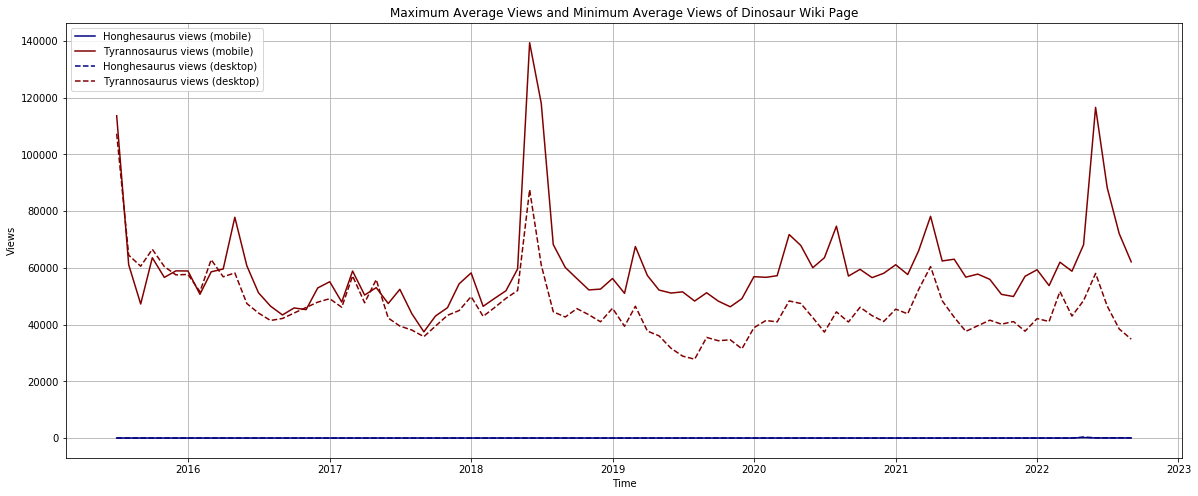

In [13]:
#########
#
#    Plot "Maximum Average and Minimum Average" 
#

# set figure size
fig = plt.figure(figsize=(20,8))
# call function to plot lines
plot_lines(list_minmax_mobile,'mobile')
plot_lines(list_minmax_desktop,'desktop')
# set label, title, and legend
plt.xlabel('Time')
plt.ylabel('Views')
plt.title('Maximum Average Views and Minimum Average Views of Dinosaur Wiki Page')
plt.legend(loc=2)
plt.grid()
plt.show()
fig.savefig('Max_Avg_Min_Avg_.png')

In [14]:
#########
#
#    Process Data for "Top 10 Peak Page Views" Plot
#

# group the max views by article names
df_monthly_desktop_grouped = df_monthly_desktop.groupby(['article'])['views'].max().reset_index()
# sort the group by result in descending order
df_monthly_desktop_sorted = df_monthly_desktop_grouped.sort_values('views', ascending=False).reset_index()
# find top 10 and least 10 max views
df_monthly_desktop_max10 = df_monthly_desktop_sorted[0:10]
# save top 10 and least 10 max/min views article names in lists
list_monthly_desktop_max10 = df_monthly_desktop_max10['article'].tolist()

# group the max views by article names
df_monthly_mobile_grouped = df_monthly_mobile.groupby(['article'])['views'].max().reset_index()
# sort the group by result in descending order
df_monthly_mobile_sorted = df_monthly_mobile_grouped.sort_values('views', ascending=False).reset_index()
# find top 10 and least 10 max views
df_monthly_mobile_max10 = df_monthly_mobile_sorted[0:10]
# save top 10 and least 10 max/min views article names in lists
list_monthly_mobile_max10 = df_monthly_mobile_max10['article'].tolist()

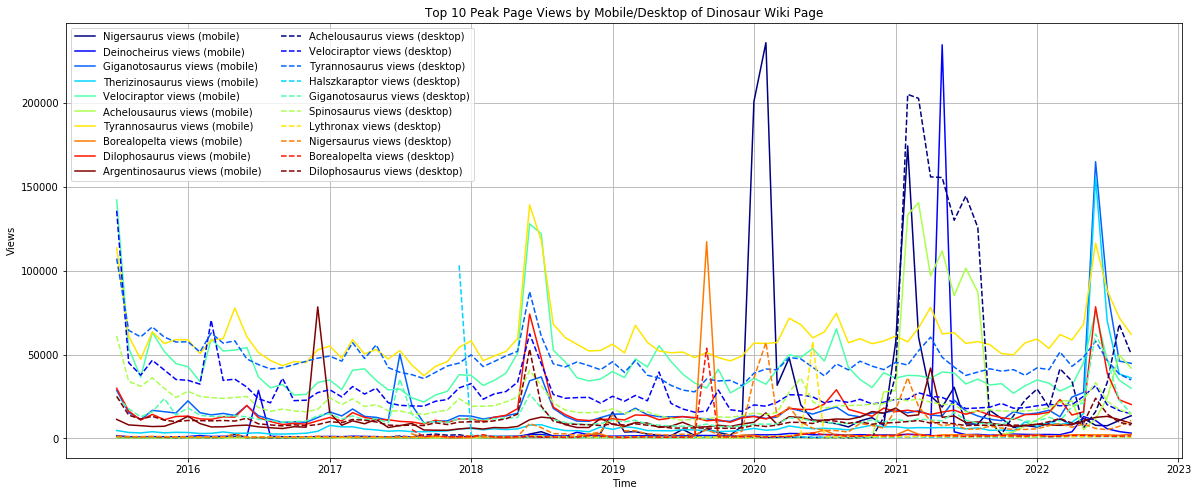

In [15]:
#########
#
#    Plot "Top 10 Peak Page Views"
#

# set figure size
fig = plt.figure(figsize=(20,8))
# call function to plot lines
plot_lines(list_monthly_mobile_max10,'mobile')
plot_lines(list_monthly_desktop_max10,'desktop')
# set label, title, and legend
plt.xlabel('Time')
plt.ylabel('Views')
plt.title('Top 10 Peak Page Views by Mobile/Desktop of Dinosaur Wiki Page')
plt.legend(ncol=2,loc=2)
plt.grid()
plt.show()
fig.savefig('Top_10_Peak_Views.png')

In [16]:
#########
#
#    Process Data for "Fewest Months of Data" Plot
#

df_monthly_desktop_grouped = df_monthly_desktop.groupby(['article']).size().reset_index(name='counts')
df_monthly_desktop_sorted = df_monthly_desktop_grouped.sort_values('counts', ascending=True).reset_index()
df_monthly_desktop_min10 = df_monthly_desktop_sorted[0:10]
list_monthly_desktop_min10 = df_monthly_desktop_min10['article'].tolist()

df_monthly_mobile_grouped = df_monthly_mobile.groupby(['article']).size().reset_index(name='counts')
df_monthly_mobile_sorted = df_monthly_mobile_grouped.sort_values('counts', ascending=True).reset_index()
df_monthly_mobile_min10 = df_monthly_mobile_sorted[0:10]
list_monthly_mobile_min10 = df_monthly_mobile_min10['article'].tolist()

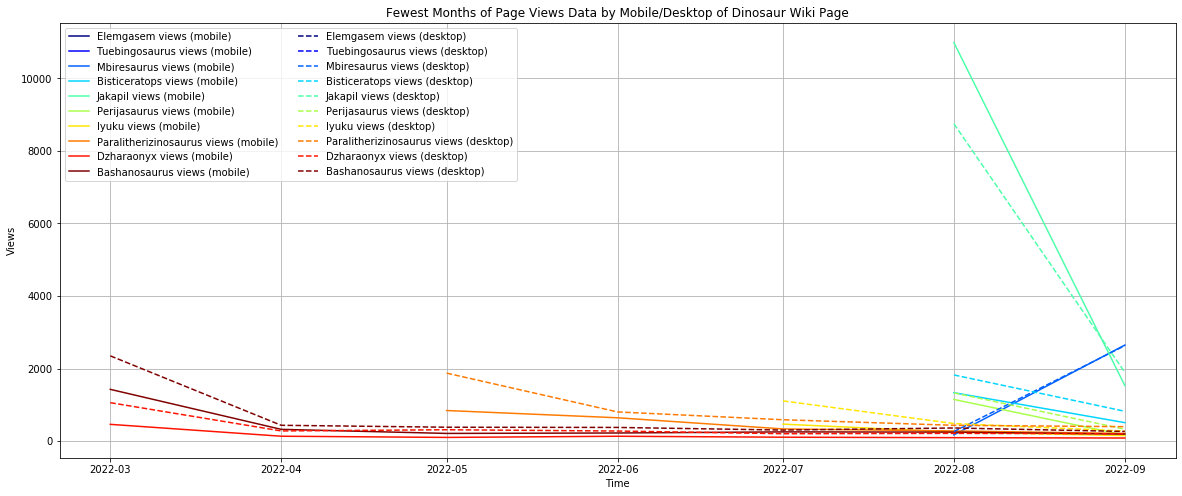

In [17]:
#########
#
#    Plot "Fewest Months of Data"
#

# set figure size
fig = plt.figure(figsize=(20,8))
# call function to plot lines
plot_lines(list_monthly_mobile_min10,'mobile')
plot_lines(list_monthly_desktop_min10,'desktop')
# set label, title, and legend
plt.xlabel('Time')
plt.ylabel('Views')
plt.title('Fewest Months of Page Views Data by Mobile/Desktop of Dinosaur Wiki Page')
plt.legend(ncol=2,loc=2)
plt.grid()
plt.show()
fig.savefig('Fewest_Months_of_Data.png')